In [37]:
# using Pkg
# Pkg.add("BenchmarkTools")
# Pkg.add("Plots")
# Pkg.add("LsqFit")
# Pkg.add("LinearAlgebra")
# Pkg.add("Images")
# Pkg.add("LaTeXStrings")

using Plots
using LsqFit
using LinearAlgebra
using Images
using LaTeXStrings
using Printf
using Random
using Statistics
using BenchmarkTools

ArgumentError: ArgumentError: Package BenchmarkTools not found in current path.
- Run `import Pkg; Pkg.add("BenchmarkTools")` to install the BenchmarkTools package.

# Exercise 1: plotting

In [38]:
# Plot N equidistant points in [0, 2π].
# If you want to type π, type "\pi", then hit the tab key.
# This works for all Greek letters.
N = 100
xs = LinRange(0, 2π, N)

# The dot indicates that the function is applied elementwise, referred to as "broadcasting".
# The semicolon ';' at the end prevents the notebook to print the return value.
ys = sin.(xs);

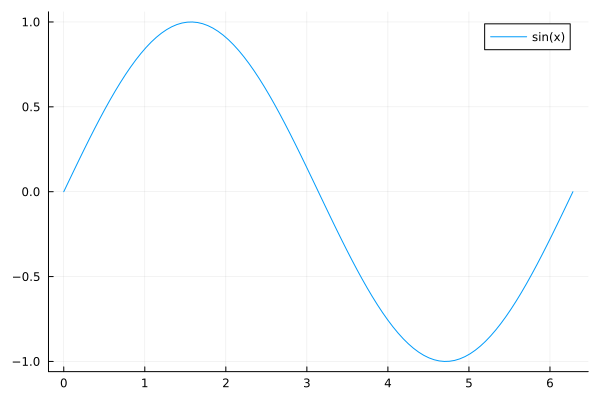

In [39]:
plot(xs, ys, label="sin(x)")

We can also plot multiple curves at once:

In [40]:
# plot(x, y, label=labels)
xs = LinRange(-π, π, 100)
plot(xs, sin.(xs), lab = "sin(x)", line = 5)
plot!(xs, cos.(xs), lab = "cos(x)", line = (5, :red, :dot))
plot!(xs, tanh.(xs), lab = "tanh(x)", line = (5, :green, :dash))
plot!(xs, xs.^2, lab = L"x^2", line = (5, :pink))  # Using L"" means that the string is read as a LaTeX expression
plot!(xlabel = "x", ylabel = "y", title = "example plot", legend = :topleft, 
    ylims = [-2.,2.], legendfontsize = 12)
png("ex01")

"ex01.png"

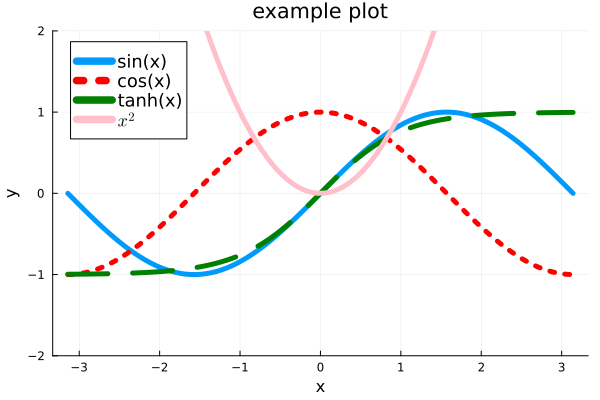

In [41]:
load("ex01.png")

# Exercise 2: data regression

In [42]:
xdata = [ 15.2; 19.9; 2.2; 11.8; 12.1; 18.1; 11.8; 13.4;
    11.5; 0.5; 18.0; 10.2; 10.6; 13.8; 4.6; 3.8; 15.1; 15.1; 11.7; 4.2 ]
ydata = [ 0.73; 0.19; 1.54; 2.08; 0.84; 0.42; 1.77; 0.86; 
    1.95; 0.27; 0.39; 1.39; 1.25; 0.76; 1.99; 1.53; 0.86; 0.52; 1.54; 1.05 ];

We want to fit the data with the following function

\[f(x) = \beta_1\frac{x}{\beta_2}\exp\left[-\left(\frac{x}{\beta_2}\right)^{\beta_3}\right]\]

Note that $\beta_1$ can be any real number, but if $\beta_2<0.0$ and $-1<\beta_3<1$ we would have complex numbers. We need to take this into account, depending on whether our solver can deal or not with complex values.

In [43]:
# The @. means that all operations in this line of code are broadcasted. It's the same as writing *. +. etc...
@. f(x, beta) = beta[1] * (x / beta[2]) * exp(-(x / beta[2])^beta[3])

f (generic function with 1 method)

Find optimal (in least squares sense) parameters:

In [44]:
?curve_fit

ErrorException: syntax: invalid identifier name "?"

In [45]:
result = curve_fit(f, xdata, ydata, [1.0, 1.0, 1.0], lower = [-Inf, 0.0, -Inf]);

β_optim = coef(result)
err = stderror(result)
[@printf("β[%d] = %.2f ± %.2f\n", i, β_optim[i], err[i]) for i = 1:3]


xs = LinRange(0, 20, 100)
ys = f(xs, β_optim);

β[1] = 4.75 ± 0.45
β[2] = 9.83 ± 1.31
β[3] = 1.89 ± 0.48


In [46]:
# Let's plot the lines of the mean and extreme values for the fit coefficients.
scatter(xdata, ydata, label = "data")
plot!(xs, ys, label = "Fit", line = 3, 
    ribbon = (ys - f(xs, β_optim - err), 
                f(xs, β_optim + err) - ys))
png("ex02")

"ex02.png"

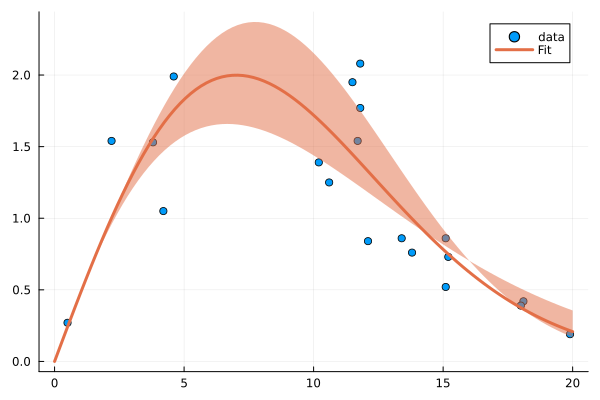

In [47]:
load("ex02.png")

## Quality of fit
The more accurate way of visualising the quality of the fit would be with Monte Carlo uncertainty quantification. You will see this method in future lectures, here you just get a taste

In [48]:
# Consider that β is actually a random variable with mean β_optim and standard deviation err.
# The idea of MC is to sample Nrep times from the random variables, then calculate the mean and standard deviation of the output. That will give us an estimate of the uncertainty.

Nrep = 3
curves = zeros(Nrep, length(xs))
for i=1:Nrep
    β_rand = β_optim + randn(3).*err
    curves[i,:] = f(xs,β_rand)
end
    
mean_curve = reshape(mean(curves, dims = 1), length(xs))
std_curve = reshape(std(curves, dims = 1), length(xs));

In [49]:
# Let's plot the lines of the mean and extreme values for the fit coefficients.
scatter(xdata, ydata, label = "data")
plot!(xs, mean_curve-std_curve, lw = 5, color = :black, lab = "Upper std. dev.")
plot!(xs, mean_curve+std_curve, lw = 5, color = :black, lab = "Lower std. dev.")
plot!(xs, mean_curve, label = "Mean fit", line = 3, 
    ribbon = (std_curve, std_curve))
png("ex02_v2")

"ex02_v2.png"

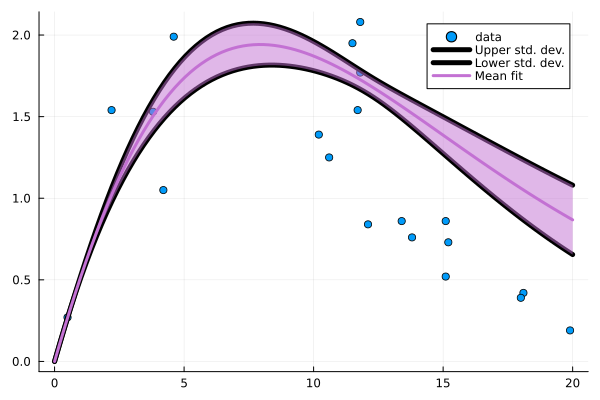

In [50]:
load("ex02_v2.png")

# Exercise 3

## Check orthogonality

Giving types to function arguments helps in debugging, findining errors during compilation, and can be used with multiple dispatch. However, typing is not necessary (Julia is afterall a "dynamically typed" language) and will in general not make your code more efficient (nor slower).

In [51]:
function is_orthogonal(M::Matrix{Float64})
    # The inverse of an orthogonal matrix is its transose, so we expect M*M'=I
    # For the identity matrix in Julia you can simply write I
    return maximum(abs.(M*M' - I)) < 1e-15
end

is_orthogonal (generic function with 1 method)

## Generate orthogonal matrices (several methods)

In [52]:
function generate_QR(n::Int64)
    # Decompose a random matrix M into M=QR, an orthogonal matrix Q and an upper triangular matrix R
    M = rand(n,n)
    q,_ = qr(M)
    return Matrix(q)
end

function generate_SVD(n::Int64)
    # Do a Singular Value Decomposition (SVD) on a random matrix M. You obtain M=UΣV, with U and V two orthogonal matrices and Σ a diagonal matrix.
    M = rand(n,n)
    u,_,v = svd(M)
    return Matrix(u), Matrix(v)
end

function generate_vectors(n::Int64)
    # Generate a random vector r and normalise it. Find its nullspace (a.k.a. kernel), which are all the vectors u such that a*u=0. The u vectors and vector a form an orthonormal basis, and thus can be joined in columns to form an orthogonal matrix
    r = rand(1,n)
    r /= norm(r,2)
    
    M = zeros(Float64, n, n)
    M[1,:] = r
    M[2:end,:] = nullspace(r)'
    
    return M
end

generate_vectors (generic function with 1 method)

In [53]:
# Quick test on all three methods:
# With @btime from the BenchmarkTools package we can test the computational time of each method. The @btime macro runs the function a few hundred times and measures the average computational time.

time_QR = @benchmark generate_QR(10)
@assert(is_orthogonal(generate_QR(3)))

time_SVD = @benchmark generate_SVD(10)
u,v = generate_SVD(3)
@assert(is_orthogonal(u))
@assert(is_orthogonal(v))

time_vec = @benchmark generate_vectors(10)
@assert(is_orthogonal(generate_vectors(4)))

LoadError: LoadError: UndefVarError: `@benchmark` not defined
in expression starting at /home/nico/Desktop/ICP/Week01/solution_00.ipynb.ipynb:4

In [54]:
println(mean(time_QR), mean(time_SVD), mean(time_vec))

UndefVarError: UndefVarError: `time_QR` not defined

## Generate matrix with specific conditioning number

In [55]:
function matgen(n::Int64, c)
    # Verify that the condition number is 1 or larger
    @assert(c >= 1.0)
    
    # Generate two random orthogonal matrices with your method of choice
    U = generate_vectors(n)
    V = generate_vectors(n)
    
    # Generate a diagonal matrix with values [1/c,1], with 1 the largest and 1/c the smallest
    # Method 1: Use values that increase with constant steps from 1/c to 1
    Σ = Diagonal(LinRange(1/c, 1.0, n))
    
    # Method 2: Use random numbers in [1/c,1]. Then make sure that the largest and smallest are 1 and 1/c
#     sings = rand(n)*(1-1/c) .+ 1/c
#     sings[1] = 1/c
#     sings[2] = 1
#     Σ = Diagonal(sings)
    
    # Now return M = UΣV
    return U * Σ * V
end

matgen (generic function with 1 method)

In [56]:
c = 4.5
M = matgen(20, c)

# Use opnorm(M,2) for the spectral norm
# Check that the largest singular value is 1
@assert(abs(opnorm(M,2) - 1) < 1e-15)

# Check that the smallest singular value is 1/c
@assert(abs(opnorm(inv(M),2) - c)/c < 1e-15)

# Check that the condition number is indeed c (plus machine precision)
# Use cond(M,2) to calculate the condition number using the Spectral norm
@assert(abs(cond(M,2) - c)/c < 1e-15)
println(cond(M,2))

4.499999999999999


In [57]:
c = 7.2
n = 5
M = matgen(n,c)
println("Using the Spectral norm ||.||_2, we get the expected condition number c = ", cond(M), "\n")

Using the Spectral norm ||.||_2, we get the expected condition number c = 7.2



In [58]:
# The Frobenius norm is computed with norm(M,2)
# Verify that the Frobenius norm of the identity of size n is √n
n = 4
@assert(norm(Matrix(I,n,n),2) == sqrt(n))

# Write a function for the condition number computed with the Frobenius norm
function cond_frobenius(M::Matrix{Float64})
    return norm(M,2) * norm(inv(M),2)
end

println("Using the Frobenius norm ||.||_F we get a different condition number,\nbut of the same order of magnitude, c = ", cond_frobenius(M))

println("\n", "Any matrix norm is valid. They will give different results, but of similar orders of magnitude.\nSome norms are more convenient to compute than others. \nCalculating the inverse of large matrices is sometimes infeasible, and using other norms that don't require the computation of the inverse can be helpful")

Using the Frobenius norm ||.||_F we get a different condition number,
but of the same order of magnitude, c = 11.68738904008367

Any matrix norm is valid. They will give different results, but of similar orders of magnitude.
Some norms are more convenient to compute than others. 
Calculating the inverse of large matrices is sometimes infeasible, and using other norms that don't require the computation of the inverse can be helpful


## Test condition number

Let us now check the statement

$$
\frac{\lVert\Delta x\rVert}{\lVert x \rVert} \leq \lVert A\rVert~\lVert A^{-1}\rVert \frac{\lVert\Delta A\rVert}{\lVert A \rVert} = c\frac{\lVert\Delta A\rVert}{\lVert A \rVert}
$$

In [59]:
c = 20
n = 2
A = matgen(n, c)
b = rand(n)
println("c = $(cond(A))\n")
#for ||dA|| / ||A|| not "small enough", the inequality fails.
x = inv(A)*b

# Now we perturb A with dA
dA = A .* 0.01 * rand(n,n)
@printf("||dA|| / ||A|| = %.2e\n", opnorm(dA,2) / opnorm(A,2))

# Now see how much x changes with the perturbed matrix A+dA
dx = x - inv(A+dA)*b
@printf("||dx|| / ||x|| = %.2e < c * ||dA|| / ||A|| = %.2e\n", norm(dx,2) / norm(x,2), c * opnorm(dA,2) / opnorm(A,2))



c = 20.000000000000014



||dA|| / ||A|| = 1.97e-03
||dx|| / ||x|| = 8.88e-03 < c * ||dA|| / ||A|| = 3.95e-02
